# Offline DDPG Agent

In [1]:
from pathlib import Path

import torch
from matplotlib import pyplot as plt
from pandas import DataFrame
from tqdm import trange
from implementations import *
import numpy as np
import pandas as pd

## Prepare dataset

In [2]:
def convert_dataframe(dataframe):
    """
    Convert a dataframe to train and test datasets
    :param dataframe: the dataframe to convert
    :return: states, actions, rewards
    """
    phase = np.deg2rad(np.array(dataframe[['phase']])[1:-1])
    dpitch = np.array(dataframe[['pitch']])[1:-1] - np.array(dataframe[['pitch']])[:-2]
    actions = np.array(dataframe[['pitch']])[2:]  #  - np.array(dataframe[['pitch']])[1:-1]
    states = DataFrame(columns=['cos_phase', 'sin_phase', 'Ct', 'Cr', 'pitch', 'dpitch'])
    states[['Ct', 'Cr', 'pitch']] = dataframe[['Ct', 'Cr', 'pitch']]
    states = states[1:-1]
    states['dpitch'] = dpitch
    states['cos_phase'] = np.cos(phase)
    states['sin_phase'] = np.sin(phase)
    states = np.array(states)[:-1]
    actions = np.array(actions)
    rewards = np.array(dataframe[['Cp']])[1:-1]
    done = np.zeros_like(rewards)
    # make episodes of 1 turn (find falling edges of phase)
    phase = np.deg2rad(np.array(dataframe[['phase']])[1:-1])
    dphase = phase[1:] - phase[:-1]
    done[np.where(dphase < 0)] = 1
    done[-1] = 1
    return states, actions, rewards, done


dataframe = pd.read_pickle('outputs/dataset/case 3/dataframes/res/vawt_data_0.pkl')
states, actions, rewards, done = convert_dataframe(dataframe)

In [3]:
states

array([[ 9.99830142e-01,  1.84306013e-02, -5.45711626e-02,
         5.02859033e-01, -8.04673084e+00,  1.47177632e-01],
       [ 9.99224447e-01,  3.93764343e-02, -2.45445999e-02,
         5.95224573e-01, -7.88916715e+00,  1.57563692e-01],
       [ 9.98179999e-01,  6.03049774e-02, -1.67989209e-04,
         6.90237516e-01, -7.72146688e+00,  1.67700270e-01],
       ...,
       [ 9.95883541e-01, -9.06419982e-02, -1.00756610e-01,
         1.17238650e-01, -8.69373231e+00,  8.91276419e-02],
       [ 9.97564159e-01, -6.97549134e-02, -5.97138879e-02,
         2.51685001e-01, -8.59296064e+00,  1.00771669e-01],
       [ 9.98806752e-01, -4.88371996e-02, -2.46728365e-02,
         3.75029357e-01, -8.48088301e+00,  1.12077631e-01]])

In [4]:
actions

array([[-7.88916715],
       [-7.72146688],
       [-7.5438917 ],
       ...,
       [-8.48088301],
       [-8.35769524],
       [-8.22360591]])

In [5]:
rewards

array([[-0.03683554],
       [-0.01656761],
       [-0.00011339],
       ...,
       [-0.04030687],
       [-0.01665416],
       [ 0.00193862]])

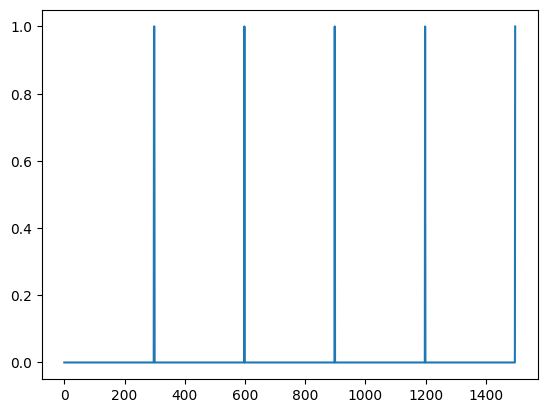

In [6]:
plt.plot(done)

In [7]:
def convert_case_df2array(dataframe_case_dir: Path):
    """
    Convert a case dataframe to train and test arrays
    :param case: the case to convert
    :return: the train and test arrays
    """
    states, actions, rewards, done = [], [], [], []
    for file in dataframe_case_dir.glob(f'*.pkl'):
        if 'full' in file.stem: continue
        dataframe = pd.read_pickle(file)
        s, a, r, d = convert_dataframe(dataframe)
        states.append(s)
        actions.append(a)
        rewards.append(r)
        done.append(d)
    states = np.concatenate(states)
    actions = np.concatenate(actions)
    rewards = np.concatenate(rewards)
    done = np.concatenate(done)
    return states, actions, rewards, done

In [8]:
dataset_type = 'res'
states, actions, rewards, done = [], [], [], []
for case_dir in dataset_cases_dir[:1]:
    df_dir = case_dir / 'dataframes' / dataset_type
    s, a, r, d = convert_case_df2array(df_dir)
    states.append(s)
    actions.append(a)
    rewards.append(r)
    done.append(d)

min_size = min([len(s) for s in states])
states = [s[:min_size] for s in states]
actions = [a[:min_size] for a in actions]
rewards = [r[:min_size] for r in rewards]
done = [d[:min_size] for d in done]

states = np.concatenate(states)
actions = np.concatenate(actions)
rewards = np.concatenate(rewards)
done = np.concatenate(done)

In [9]:
# normalize states and actions
states_means, states_stds = np.mean(states, axis=0), np.std(states, axis=0)
actions_means, actions_stds = np.mean(actions, axis=0), np.std(actions, axis=0)
states = (states - states_means) / states_stds
actions = (actions - actions_means) / actions_stds
rewards = (rewards - np.mean(rewards)) / np.std(rewards)

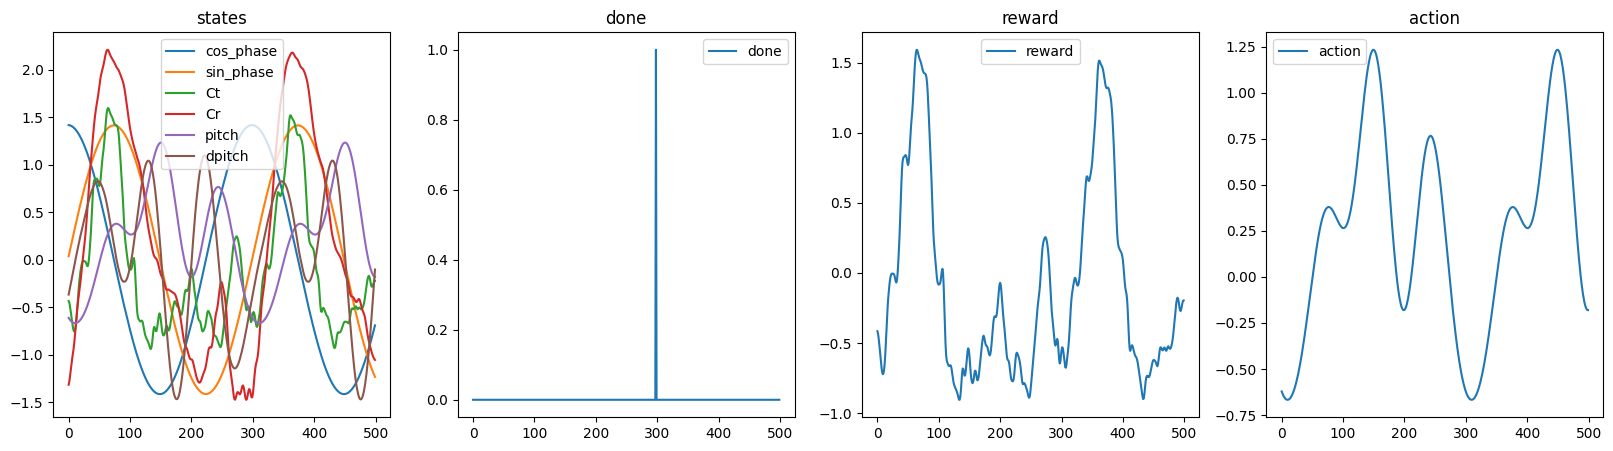

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
n = 500
ax[0].plot(states[:n], label=x_columns[:-1])
ax[0].set_title('states')
ax[0].legend()
ax[1].plot(done[:n], label='done')
ax[1].set_title('done')
ax[1].legend()
ax[2].plot(rewards[:n], label='reward')
ax[2].set_title('reward')
ax[2].legend()
ax[3].plot(actions[:n], label='action')
ax[3].set_title('action')
ax[3].legend()
plt.show()

In [11]:
action_bounds = min(actions).item(), max(actions).item()  # compute bounds on normalized datas

## DDPG Agent

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
ddpg_actor_learning_rate = 1e-3
ddpg_critic_learning_rate = 1e-3
ddpg_gamma = .9  # discount factor Q = r + gamma * Q(s', a')

ddpg_hard_updates = True
# for hard updates ddpg_target_network update frequency
early_target_network_update_frequency = 50
switch_iteration = 10000
later_target_network_update_frequency = 200
ddpg_target_network_update_frequency = early_target_network_update_frequency
# for soft updates ddpg_tau
ddpg_tau = .99

num_ite = 40000 # 20000
gamma_actor_sch = .9 # .8
gamma_critic_sch = .9 # .8
sch_step_size = 1000

In [14]:
def clip_action(action: torch.tensor) -> torch.tensor:
    """
    Try like a scaled and shifted sigmoid thing.
    https://www.reddit.com/r/reinforcementlearning/comments/f909bl/ddpg_action_space_limitation/
    :param action: the action to clip
    :return: the clipped action
    """
    min_action, max_action = action_bounds
    # normalize min and max action
    min_action = ((min_action - actions_means) / actions_stds).item()
    max_action = ((max_action - actions_means) / actions_stds).item()

    """action = torch.sigmoid(action)
    action = action * (max_action - min_action) + min_action"""
    action = torch.clamp(action, min_action, max_action)
    return action


class DDPGAgent:
    def __init__(self):
        # randomly initialize critic network Q(s,a|theta_Q) and actor mu(s|theta_mu) with weights theta_Q and theta_mu
        self.critic = create_mlp(widths=ddpg_critic_model_layer_widths).to(device)
        self.actor = create_mlp(widths=ddpg_actor_model_layer_widths).to(device)
        # initialize target network Q' and mu' with weights theta_Q' = theta_Q and theta_mu' = theta_mu
        self.critic_target = create_mlp(widths=ddpg_critic_model_layer_widths).to(device)
        self.actor_target = create_mlp(widths=ddpg_actor_model_layer_widths).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.actor_target.load_state_dict(self.actor.state_dict())
        # initialize replay buffer R (state_t, action_t, reward_t, state_t+1, done_t+1)
        self.replay_buffer_state_t = torch.Tensor(states[:-1]).to(device)
        self.replay_buffer_action_t = torch.Tensor(actions[:-1]).to(device)
        self.replay_buffer_reward_t = torch.Tensor(rewards[:-1]).to(device)
        self.replay_buffer_state_t1 = torch.Tensor(states[1:]).to(device)
        self.replay_buffer_done_t1 = torch.Tensor(done[1:]).to(device)
        self.replay_buffer_counter = 0

        # temporary variables s_{t-1}, a_{t-1}
        self.last_states, self.last_actions = None, None

        # learning variables
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=ddpg_critic_learning_rate)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=ddpg_actor_learning_rate)

        # train mode by default
        self.__eval_mode = False
        self.counter = 0

    def eval(self):
        self.__eval_mode = True
        self.actor.eval()
        self.critic.eval()
        self.actor_target.eval()
        self.critic_target.eval()

    def train(self):
        self.__eval_mode = False
        self.actor.train()
        self.critic.train()
        self.actor_target.train()
        self.critic_target.train()

    def __call__(self, states: torch.tensor) -> torch.tensor:
        actions = self.actor(states).detach()
        actions = actions.detach().squeeze(1)
        # clip actions
        actions = clip_action(actions)
        return actions

    def train_step(self):
        # sample a random minibatch of N transitions (s_i, a_i, r_i, s_i+1) from R
        minibatch_indices = np.random.randint(0, len(self.replay_buffer_state_t), size=ddpg_batch_size)

        # convert to tensors
        minibatch_st = self.replay_buffer_state_t[minibatch_indices]
        minibatch_at = self.replay_buffer_action_t[minibatch_indices]
        minibatch_rt = self.replay_buffer_reward_t[minibatch_indices]
        minibatch_st1 = self.replay_buffer_state_t1[minibatch_indices]
        minibatch_done = self.replay_buffer_done_t1[minibatch_indices]

        # set y_i = r_i + gamma * Q'(s_i+1, mu'(s_i+1|theta_mu')|theta_Q')
        next_actions = self.actor_target(minibatch_st1)
        # clip next action
        next_actions = clip_action(next_actions)

        target_Q = minibatch_rt + ddpg_gamma * self.critic_target(
            torch.cat((minibatch_st1, next_actions), dim=1)
        ) * (1 - minibatch_done)
        # update critic by minimizing the loss L = 1/N * sum_i (y_i - Q(s_i, a_i|theta_Q))^2
        current_Q = self.critic(torch.cat((minibatch_st, minibatch_at), dim=1))
        loss_critic = torch.nn.MSELoss()(current_Q, target_Q)
        self.critic_optimizer.zero_grad()
        loss_critic.backward()
        self.critic_optimizer.step()
        # update the actor policy using the sampled policy gradient
        # do gradient ascent on the actor
        actions = self.actor(minibatch_st)
        # clip actions
        actions = clip_action(actions)
        loss_actor = -self.critic(torch.cat((minibatch_st, actions), dim=1)).mean()
        self.actor_optimizer.zero_grad()
        loss_actor.backward()
        self.actor_optimizer.step()
        # update the target networks
        if ddpg_hard_updates and self.counter % ddpg_target_network_update_frequency == 0:
            # hard update
            self.critic_target.load_state_dict(self.critic.state_dict())
            self.actor_target.load_state_dict(self.actor.state_dict())
        # for soft updates
        elif not ddpg_hard_updates:
            # soft update
            for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
                target_param.data.copy_((1 - ddpg_tau) * param.data + ddpg_tau * target_param.data)
            for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
                target_param.data.copy_((1 - ddpg_tau) * param.data + ddpg_tau * target_param.data)
        self.counter += 1
        return loss_critic.item(), loss_actor.item()

    def save(self, path, infos=None):
        if infos is None:
            infos = {}

        path = str(path)
        # remove .zip extension if present
        if path.endswith('.zip'):
            path = path[:-4]
        directory = os.path.dirname(path)
        filename_no_ext = os.path.basename(path)
        actor_filename = f"{filename_no_ext}_actor"
        critic_filename = f"{filename_no_ext}_critic"

        actor_info = infos.copy()
        actor_info.update({"type": "actor", "layer_widths": ddpg_actor_model_layer_widths})
        critic_info = infos.copy()
        critic_info.update({"type": "critic", "layer_widths": ddpg_critic_model_layer_widths})

        save_model(self.actor, actor_filename, actor_info)
        save_model(self.critic, critic_filename, critic_info)

        with zipfile.ZipFile(f"{path}.zip", "w") as zipf:
            zipf.write(f"{directory}/{actor_filename}.zip")
            zipf.write(f"{directory}/{critic_filename}.zip")

        os.remove(f"{directory}/{actor_filename}.zip")
        os.remove(f"{directory}/{critic_filename}.zip")

    def load(self, path):
        with zipfile.ZipFile(path, "r") as zipf:
            zipf.extractall()
        filename_no_ext = os.path.basename(path)[:-4]

        # Construct the filenames for the actor and critic models
        actor_filename = f"{filename_no_ext}_actor.zip"
        critic_filename = f"{filename_no_ext}_critic.zip"

        # Load the actor and critic models from the extracted files
        self.actor = load_model(actor_filename)
        self.critic = load_model(critic_filename)

        # Remove the extracted zip files
        os.remove(model_dir / f"{actor_filename}")
        os.remove(model_dir / f"{critic_filename}")

In [15]:
agent = DDPGAgent()

In [16]:
agent.train()
losses = []
_trange = trange(num_ite, desc='loss', leave=True, unit='batch')
actor_scheduler = torch.optim.lr_scheduler.StepLR(agent.actor_optimizer, step_size=sch_step_size, gamma=gamma_actor_sch)
critic_scheduler = torch.optim.lr_scheduler.StepLR(agent.critic_optimizer, step_size=sch_step_size,
                                                   gamma=gamma_critic_sch)
for iteration in _trange:
    loss_critic, loss_actor = agent.train_step()
    losses.append((loss_critic, loss_actor))
    _trange.set_description(f'loss: critic:{loss_critic:.3f}, actor:{loss_actor:.3f} '
                            f'lr: critic:{agent.critic_optimizer.param_groups[0]["lr"]:.3e} '
                            f'actor:{agent.actor_optimizer.param_groups[0]["lr"]:.3e}')
    _trange.refresh()
    actor_scheduler.step()
    critic_scheduler.step()
    if iteration == switch_iteration:
        ddpg_target_network_update_frequency = later_target_network_update_frequency

loss: critic:0.138, actor:-3.902 lr: critic:1.642e-05 actor:1.642e-05: 100%|██████████| 40000/40000 [18:45<00:00, 35.53batch/s]


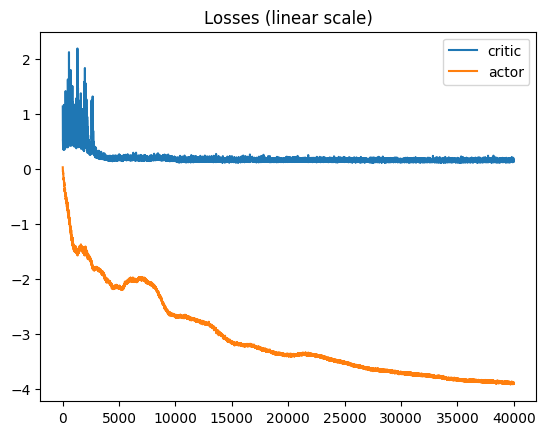

In [17]:
plt.plot([l[0] for l in losses], label='critic')
plt.plot([l[1] for l in losses], label='actor')
plt.legend()
plt.title('Losses (linear scale)')
plt.show()

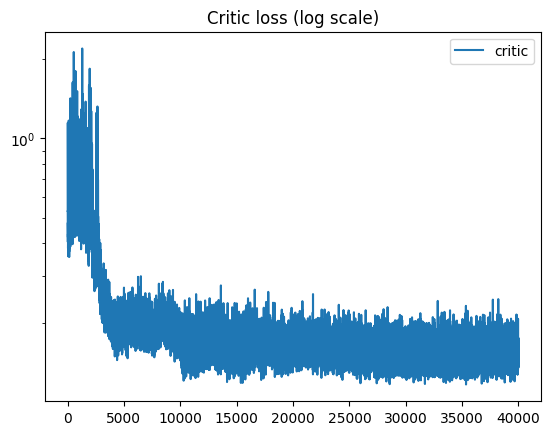

In [18]:
plt.yscale('log')
plt.plot([l[0] for l in losses], label='critic')
plt.title('Critic loss (log scale)')
plt.legend()
plt.show()

In [19]:
losses[-1][0]

0.13838277757167816

## Save agent

In [20]:
agent.save('outputs/models/ddpg_agent_offline.zip')

## Test

In [21]:
tdataframe = pd.read_pickle('outputs/dataset/case 2/dataframes/res/ms006mpt001.pkl')[:1000]  # test dataframe
tstates, tactions, trewards, tdone = convert_dataframe(tdataframe)
# normalize states
tstates = (tstates - states_means) / states_stds
# normalize actions
tactions = (tactions - actions_means) / actions_stds

In [22]:
agent.eval()
pred_actions = agent(torch.Tensor(tstates).to(device)).to('cpu').detach().numpy()

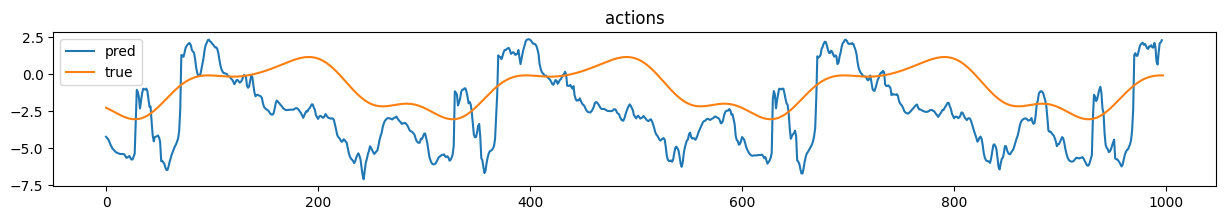

In [23]:
plt.plot(pred_actions, label='pred')
plt.plot(tactions, label='true')
plt.legend()
plt.title('actions')
fig = plt.gcf()
fig.set_size_inches(15, 2)
plt.show()

In [26]:
from ipywidgets import interact


@interact(actor=True, critic=True)
def plot_q_values(actor=True, critic=True):
    # plot q-values of every action at every state of the episode on a heatmap
    n_actions, n_states = 100, 700
    all_actions = np.linspace(*action_bounds, n_actions)
    all_states = tstates[:n_states]
    all_states = np.repeat(all_states, len(all_actions), axis=0)
    all_actions = np.tile(all_actions, len(all_states) // len(all_actions))
    all_actions = all_actions.reshape(-1, 1)
    all_states = torch.Tensor(all_states).to(device)
    all_actions = torch.Tensor(all_actions).to(device)
    all_q_values = agent.critic(torch.cat((all_states, all_actions), dim=1)).detach().to('cpu').numpy()
    all_q_values = all_q_values.reshape(n_states, n_actions)
    plt.imshow(all_q_values.T, aspect='auto')
    # plot over it the best actions
    if critic:
        best_actions = np.argmax(all_q_values, axis=1)
        plt.plot(best_actions, label='argmax', color='r', linewidth=1, linestyle='--')
    # plot over it actions determined by the actor
    if actor:
        actor_actions = agent(torch.Tensor(tstates[:n_states]).to(device)).to('cpu').numpy()
        actor_actions = np.interp(actor_actions, (actor_actions.min(), actor_actions.max()), (0, n_actions))
        plt.plot(actor_actions, label='actor', color='w', linewidth=1, linestyle='--')
    plt.legend()
    plt.colorbar()
    plt.title('Q-values')
    plt.ylabel('action')
    plt.xlabel('state')
    plt.yticks(np.linspace(0, n_actions, 5), [f'{x:.3f}' for x in np.linspace(*action_bounds, 5)])
    plt.xticks(np.linspace(0, n_states, 5), np.linspace(0, n_states, 5))
    # set fig size
    fig = plt.gcf()
    fig.set_size_inches(15, 2)
    # invert y axis
    plt.gca().invert_yaxis()
    plt.show()

interactive(children=(Checkbox(value=True, description='actor'), Checkbox(value=True, description='critic'), O…

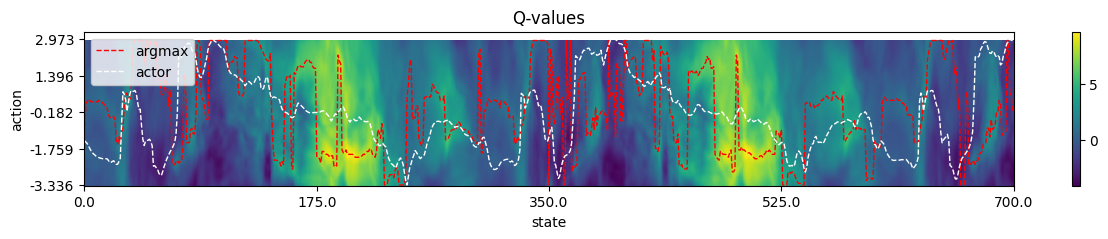

In [27]:
plot_q_values(actor=True, critic=True)